## Bounding Box Generation from Class Activation Maps

In [1]:
from fastai.vision.all import *
from fastai.medical.imaging import *
from fmi.preprocessing import *
from fmi.train import *
from fmi.examine import *
import pydicom

matplotlib.rcParams['image.cmap'] = 'viridis'

This notebook uses the approach of generating bounding boxes from Class Activation Maps (CAM). CAM was introduced by Bolei Zhou et al. in the paper [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150) and is a great tool for model interpretation.

Grad CAM is a variation of CAM that was introduced in [Grad-CAM: Why Did You Say That? Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1611.07450)

Grad CAM is similar to CAM in that it is a weighted combination of feature maps but followed by a ReLU. The output of Grad CAM is a “class-discriminative localization map” where the hot part of the heatmap corresponds to a particular class. 

CAM uses the output of the last convolutional layer to provide a heatmap visualization.  A way of acccessing the activations during the training phase in Pytorch is done by using a hook. A hook is basically a function that is executed when either the forward or backward pass is called.

`Fastai` conveniently has a `Hook` class

In [2]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

The gradients of every layer are calculated by PyTorch during the backward pass. To access the gradients you can register a hook on the backward pass and store these gradients. 

Again conveniently `fastai` has the `HookBwd` class.

In [3]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

### Create the DataBlock

Create the DataBlock and load a model based on this [notebook](http://localhost:8889/notebooks/fmi/tutorial_nbs/medical_imaging_tutorial.ipynb)

In [4]:
pneu = untar_data(URLs.SIIM_SMALL)
df = pd.read_csv(f'{pneu}/labels.csv')
p_items = get_dicom_files(f'{pneu}/train')

item_tfms = Resize(266)
batch_tfms = [RandomResizedCropGPU(226), *aug_transforms(do_flip=False, flip_vert=False, max_rotate=10.,
                                                         min_zoom=1., max_zoom=1.1, max_lighting=0.2, max_warp=0.1),
                                                         Normalize.from_stats(*imagenet_stats)]

splitter = dicom_splitter(p_items, valid_pct=0.2, seed=7)

pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneu/f"{x[0]}",
                   get_y=lambda x:x[1],
                   splitter=splitter,
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)

dls = pneumothorax.dataloaders(df.values, bs=32, num_workers=0)

learn = timm_learner(dls, 
                    'resnetblur50' ,
                     pretrained=True,
                    loss_func=LabelSmoothingCrossEntropyFlat(), 
                    metrics=accuracy, 
                    cbs=[ShowGraphCallback(), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=1),\
                         GradientClip, \
                         SaveModelCallback(monitor='accuracy',fname='siim_small_best',comp=np.greater, with_opt=True)])

learn.load('test_one')

200 50


### Generating the heatmaps

This is the walk through of how the heatmaps are generated.  First we grab an image.

In [5]:
test_path = 'C:/Users/avird/.fastai/data/siim_small/test'
test_files = get_dicom_files(test_path)
test_one = test_files[0]

We can use `learn.predict` to predict the class of the test image. This returns the class, prediction and probabilities

In [6]:
cl, pred, probs = learn.predict(test_one)
print(cl, pred, probs)

Pneumothorax tensor(1) tensor([0.4179, 0.5821])


To be able to generate the correct heatmap for the predicted class `Pneumothorax` we need to pass the predicted tensor value which is 1 when generating the heatmap.  Recall that the number of classes in a dataset can be found by doing:

In [7]:
dls.vocab

['No Pneumothorax', 'Pneumothorax']

Where `No Pneumothorax` is class 0 and `Pneumothorax` is class 1

You can define the predicted tensor like so:

In [8]:
cls = pred.item()
cls

1

`first` is handy `fastcore` function that takes the first item in a list.  In this case we can create a list comprehension of files in the test folder and x will be the first item in that folder

In [9]:
x, = first(dls.test_dl([file for file in test_files]))

Generate the image

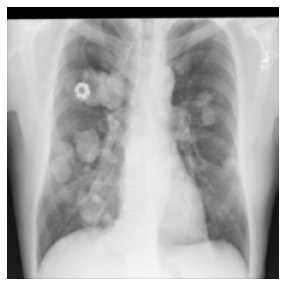

In [10]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
x_dec.show();

Grab the gradients using `Hook` and `HookBwd` and here we are grabbing them from the last layer `learn.model[0][-1]`

In [11]:
with HookBwd(learn.model[0][-1]) as hookg:
    with Hook(learn.model[0][-1]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0, cls].backward()
    grad = hookg.stored

Generate the heatmap

In [12]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

Check the shape of cam_map

In [13]:
cam_map.shape

torch.Size([8, 8])

In this case the heatmap is a 8 by 8 square. Note that the shape of cam_map is determined by the item_tfms shape set in the DataBlock. The larger the image used during training the larger the heat map.

We can view the heatmap using show_image

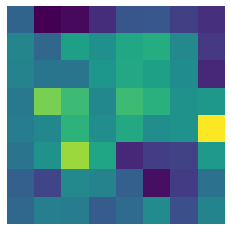

In [14]:
show_image(cam_map, figsize=(4,4));

The location on the heatmap that has the highest activations is the bright yellow square at position (4, 7).

We can view the heatmap on the image like so:

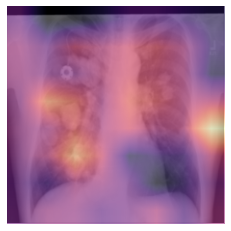

In [15]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0, x_dec.shape[1], x_dec.shape[2],0),
              interpolation='bilinear', cmap='magma');

### How do you generate the bounding boxes?

Now we need to be able to generate a bounding box around the area with the highest activation.

To do this we need to iterate over the cam_map values and get the indexes of the x and and y locations where the activations are the highest.

cam_map is a 8 by 8 `TensorDicom`

In [16]:
cam_map, cam_map.shape

(TensorDicom([[-0.0246, -0.0848, -0.0802, -0.0605, -0.0345, -0.0341, -0.0491, -0.0596],
         [ 0.0005, -0.0228,  0.0213,  0.0095,  0.0268,  0.0313,  0.0037, -0.0534],
         [-0.0007, -0.0120, -0.0121,  0.0140,  0.0280,  0.0216,  0.0066, -0.0631],
         [-0.0088,  0.0642,  0.0437,  0.0027,  0.0433,  0.0345,  0.0109,  0.0153],
         [-0.0062,  0.0024,  0.0364,  0.0073,  0.0283,  0.0068,  0.0115,  0.1026],
         [-0.0129,  0.0109,  0.0742,  0.0251, -0.0632, -0.0507, -0.0478,  0.0168],
         [-0.0272, -0.0457,  0.0034, -0.0008, -0.0272, -0.0772, -0.0522, -0.0150],
         [-0.0216, -0.0038, -0.0061, -0.0299, -0.0190,  0.0058, -0.0392, -0.0005]],
        device='cuda:0'),
 torch.Size([8, 8]))

Convert the cam_map into a tensor but first we need to copy the tensor to host memory first by using `.cpu()`

In [17]:
arr = np.array(cam_map.cpu())
ten_map = tensor(arr)

Find the value of the tensor with the maximum value

In [18]:
ten_map.max()

tensor(0.1026)

Now to get the indexes of the maximum tensor we start by first finding the maximum value in each of the rows in `ten_map`

In [21]:
val = []
for i in range(0, ten_map.shape[0]):
    index, value = max(enumerate(ten_map[i]), key=operator.itemgetter(1))
    val.append(value)

In [22]:
val

[tensor(-0.0246),
 tensor(0.0313),
 tensor(0.0280),
 tensor(0.0642),
 tensor(0.1026),
 tensor(0.0742),
 tensor(0.0034),
 tensor(0.0058)]

We now have the maximum value of each row. Now to get the y_index and confirm that it matches the maximum value

In [23]:
y_index, y_value = max(enumerate(val), key=operator.itemgetter(1))
print(y_index, y_value)

4 tensor(0.1026)


The highest value of `0.1026` is found at index 4(remember that indexes start from 0 so index 4 is the 5th row)

Get the x_index

In [25]:
x_index, x_value = max(enumerate(ten_map[y_index]), key=operator.itemgetter(1))
x_index, x_value

(7, tensor(0.1026))

We can confirm that the highest value (0.1026) can be found at index [4,7]

Now we need to match that index to the image

To do this we need to know the shape of the image

In [26]:
imz = pydicom.dcmread(test_files[0]).pixel_array 
imz.shape

(1024, 1024)

And since the heatmap is broken down into 8 by 8 squares we need to divide the image into 8 by 8 sections so that they correspond to each section of the heatmap.  In this case the image is already a square but in reality it is not usually the case.

In [27]:
cms = cam_map.shape[0]
cms

8

Along the x-axis

In [28]:
x_ = imz.shape[1] // cms
x_

128

Along the y-axis

In [29]:
y_ = imz.shape[0] // cms
y_

128

So the image now has 8 by 8 squares each of size 128 by 128.

To match the square with highest activations we multiply the x and y indexes we calculated earlier to the size of each square

In [30]:
x = x_index * x_
x

896

In [31]:
y = y_index * y_
y

512

Using `TensorBBox` we can now plot a bounding box around the area of the image which has the highest activations

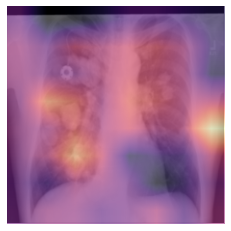

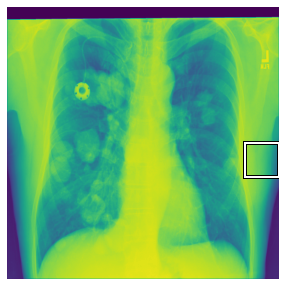

In [32]:
box = TensorBBox([x,y, (x + (imz.shape[0]//cms)),(y + (imz.shape[1]//cms))])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0, x_dec.shape[1], x_dec.shape[2],0),
              interpolation='bilinear', cmap='magma');
ctx = show_image(imz)
box.show(ctx=ctx);

### get_maps

`get_cmaps` is a handy `fmi` function from where you can easily view activation maps

first we have to define which layer in the model you want to view. For this case I want to view the last layer

In [33]:
layer = learn.model[0][7][-1]

get_cmaps allows for some flexibility:

- sanity = if you want to check actual values
- show_maps = display the class activation map
- show_cmap = display the test image with the class activation map super-imposed

Pneumothorax
tensor([1, 0])
tensor([0.5821, 0.4179])


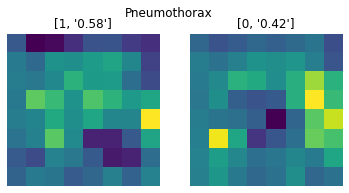

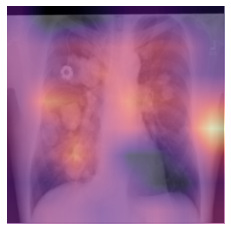

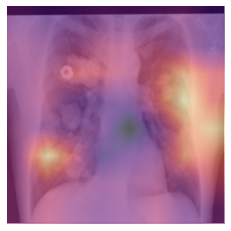

In [34]:
get_cmaps(test_one, dls, learn, layer=layer, sanity=True, show_maps=True, show_cmap=True)

The predicted class for this image is `Pneumothorax` which is tensor 1 with a probability of `0.58`.

`get_cmaps` displays the activation maps of each class (predicted first) and also displays the image with super imposed activation maps

### get_boxes

`get_boxes` creates bounding boxes at locations with the highest activations in each class activation map

[array([ 896,  512, 1024,  640]), array([768, 384, 896, 512])]

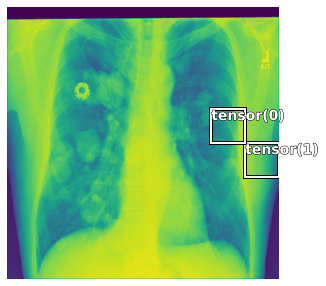

In [37]:
get_boxes(test_one, dls, learn, layer=layer, sanity=False , show_maps=False, show_img=True, color='white')